In [1]:
import numpy as np
import gym
import jax
import jax.numpy as jnp
from jax import random


from utils import experience
from value_prediction import approximator 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
key = random.PRNGKey(42)

## test `Accumulator`

In [3]:
def random_transition(rng_key):
  keys = random.split(rng_key, 5)
  action = random.normal(keys[0])
  step_type = random.choice(keys[1], np.array([0,1]), (), p=np.array([0.8,0.2]))
  obsv = random.normal(keys[2], (5,))
  reward = random.normal(keys[3])
  discount = random.normal(keys[4])
  timestep = experience.TimeStep(step_type, obsv, reward, discount)
  return action, timestep

In [4]:
num_trial = 20
acc = experience.Accumulator(100,10, 1000)
for _ in range(num_trial):
  key, rng_key = random.split(key)
  acc.push(*random_transition(rng_key))

In [5]:
if acc.len_ep():
  key, rng_key = random.split(key)
  ep = acc.sample_one_ep(rng_key=rng_key)
  a_tm1, timesteps = ep
  print(a_tm1)
  print(timesteps.obsv.shape)
  print(timesteps.reward)

[-0.70174843  0.20130268  0.38878742  0.4490586  -0.4645598  -0.6335572
  0.70128465  1.1678793 ]
(8, 5)
[-0.04916107  0.6990545  -1.8962104   0.41176248  0.35624167  0.71857476
 -0.68384737 -0.8546467 ]


In [6]:
key, rng_key = random.split(key)
batch_ts = acc.sample_batch_transtions(rng_key, 10)
print(batch_ts)
%timeit batch_ts = acc.sample_batch_transtions(rng_key, 10)

Transition(s_tm1=array([[-1.1851362 ,  0.23247516,  0.62144095,  1.8605717 ,  1.8397988 ],
       [-1.1851362 ,  0.23247516,  0.62144095,  1.8605717 ,  1.8397988 ],
       [-0.20277615, -1.0688035 ,  0.55209756,  1.2560601 ,  0.40781483],
       [ 0.84906757,  1.180224  , -0.35087636,  1.8997042 ,  0.41478625],
       [-1.3641362 , -0.8225158 ,  0.07115824,  0.40383402, -2.0227284 ],
       [ 2.0324206 , -1.2778237 , -1.2031468 , -0.9678224 ,  1.6807313 ],
       [-0.20277615, -1.0688035 ,  0.55209756,  1.2560601 ,  0.40781483],
       [-1.0662831 , -0.37013066,  0.8649993 ,  0.35847834, -1.9946321 ],
       [-0.20277615, -1.0688035 ,  0.55209756,  1.2560601 ,  0.40781483],
       [ 0.41062924,  0.26214984,  1.2928363 , -2.6725428 , -0.74324137]],
      dtype=float32), a_tm1=array([ 1.2919614 ,  1.2919614 ,  0.8703184 ,  0.8670506 , -0.4645598 ,
       -0.55330265,  0.8703184 ,  0.17375942,  0.8703184 ,  0.38878742],
      dtype=float32), s_t=array([[-1.0662831 , -0.37013066,  0.864999

### test `Accumulator` with `gym` environment

#### Blackjack-v1

In [8]:
env = gym.make('Blackjack-v1')
env.observation_space, env.observation_space[0].n

(Tuple(Discrete(32), Discrete(11), Discrete(2)), 32)

In [9]:
acc = experience.Accumulator(100,10)
num_ep = 10

for _ in range(num_ep):
    discount = 1
    gamma = 0.9 # could be gamma*lambda*lho
    observation = env.reset()
    acc.push(None, experience.TimeStep(obsv = np.array(observation)))
    for _ in range(100):
        action = env.action_space.sample()
        # print(observation)
        observation, reward, done, info = env.step(action)
        acc.push(action, experience.TimeStep(
            int(done),
            np.array(observation),
            reward,
            discount
        ))
        discount*=gamma
        if done:
            break

In [10]:
if acc.len_ep():
  key, rng_key = random.split(key)
  ep = acc.sample_one_ep(rng_key=rng_key)
  a_tm1, timesteps = ep
  print("actions", a_tm1)
  print("observations'", timesteps.obsv)
  print("rewards", timesteps.reward)

actions [0 0]
observations' [[13 10  0]
 [13 10  0]]
rewards [ 0. -1.]


In [6]:
appr = approximator.tabularApproximator([np.arange(sp.n) for sp in env.observation_space])

In [8]:
jax.jit(jax.vmap(appr.v))(timesteps.obsv)

DeviceArray([0., 0.], dtype=float32)

#### CartPole

In [7]:
env = gym.make('CartPole-v1')

In [9]:
acc = experience.Accumulator(100, 10, 1000)
num_ep = 10

for _ in range(num_ep):
    discount = 1
    gamma = 0.9 # could be gamma*lambda*lho
    observation = env.reset()
    acc.push(None, experience.TimeStep(obsv = np.array(observation)))
    for _ in range(100):
        action = env.action_space.sample()
        # print(observation)
        observation, reward, done, info = env.step(action)
        acc.push(action, experience.TimeStep(
            int(done),
            np.array(observation),
            reward,
            discount
        ))
        discount*=gamma
        if done:
            break

In [10]:
if acc.len_ep():
  key, rng_key = random.split(key)
  ep = acc.sample_one_ep(rng_key=rng_key)
  a_tm1, timesteps = ep
  print("actions", a_tm1)
  print("observations' shape", timesteps.obsv.shape)
  print("cartpole angles", timesteps.obsv[:, 2]) # terminate when out-of-screen or |angle|> .21 rad
  print("rewards", timesteps.reward)

actions [0 1 1 0 1 1 0 1 1 1 0 1 1]
observations' shape (13, 4)
cartpole angles [-0.02263594 -0.02253525 -0.02842932 -0.04031748 -0.04653375 -0.05885243
 -0.07731049 -0.09029609 -0.10960153 -0.13529953 -0.16749537 -0.19473866
 -0.22878294]
rewards [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [12]:
key, rng_key = random.split(key)
batch_ts = acc.sample_batch_transtions(rng_key, 10)
print(batch_ts)

Transition(s_tm1=array([[-0.07135496, -0.8044884 ,  0.06275153,  1.1860069 ],
       [-0.04107616, -0.40775284,  0.03311366,  0.62704134],
       [ 0.01912542,  0.19686364,  0.04535092, -0.2630621 ],
       [ 0.04613332, -0.21983969, -0.03070908,  0.2951598 ],
       [-0.02069465,  0.72586673,  0.12915693, -0.5136689 ],
       [-0.06229383, -0.42049897,  0.06574982,  0.61457974],
       [ 0.01527742, -0.39159405,  0.0568476 ,  0.68436843],
       [-0.03143155,  0.72875226,  0.02726706, -0.807868  ],
       [-0.05793046, -0.15074818,  0.03204959,  0.28395575],
       [ 0.00440638,  0.33258024,  0.11521881,  0.14445812]],
      dtype=float32), a_tm1=array([1, 0, 0, 0, 0, 1, 1, 1, 1, 1]), s_t=array([[-0.08744472, -0.6102339 ,  0.08647167,  0.9136355 ],
       [-0.04923122, -0.60332096,  0.04565448,  0.92996633],
       [ 0.0230627 ,  0.00112468,  0.04008968,  0.04357307],
       [ 0.04173653, -0.4145107 , -0.02480589,  0.57800156],
       [-0.00617732,  0.5291849 ,  0.11888355, -0.1832368

# test `TD`

In [4]:
from value_prediction import td

In [11]:
print(td.td_zero_error(0, 1, 1, 1))
# jitted_nstep_td_errors = jax.jit(td.nstep_td_errors, static_argnums=(0,))
# print(jitted_nstep_td_errors(3, jnp.zeros(4), jnp.array([1, 2, 3, 4]), jnp.ones(4), .5))

print(td.nstep_td_errors(3, jnp.zeros(4), jnp.array([1, 2, 3, 4]), jnp.ones(4), .5))
print(td.td_lambda_errors(.5, jnp.zeros(4), jnp.array([1, 2, 3, 4]), jnp.zeros(4), 1))

2
[2.875 4.625]
[3.25 4.5  5.   4.  ]


In [12]:
%timeit td.nstep_td_errors(3, jnp.zeros(4), jnp.array([1, 2, 3, 4]), jnp.ones(4), .5)
%timeit td.td_lambda_errors(.5, jnp.zeros(4), jnp.array([1, 2, 3, 4]), jnp.zeros(4), .9)

827 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
822 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# test `agents`

In [3]:
from utils import experiment
from agents import *

## random policy tabular agent

In [4]:
env = gym.make('Blackjack-v1')
# appr = approximator.tabularApproximator([np.arange(sp.n) for sp in env.observation_space])
agent = agents.RandomAgent(env, learning_rate=0.1)
acc = experience.Accumulator(100,10)
trainer = experiment.Trainer(env, acc, './log/test_rand_blackjack/exp2')

In [9]:
train_episodes = 10000
key, train_key = random.split(key)
trainer.train(train_key, agent, train_episodes)

100%|███████████████| 10000/10000 [01:39<00:00, 100.28it/s]


In [10]:
v = agent.appr.table

Text(0.5, 0, 'v (no ace)')

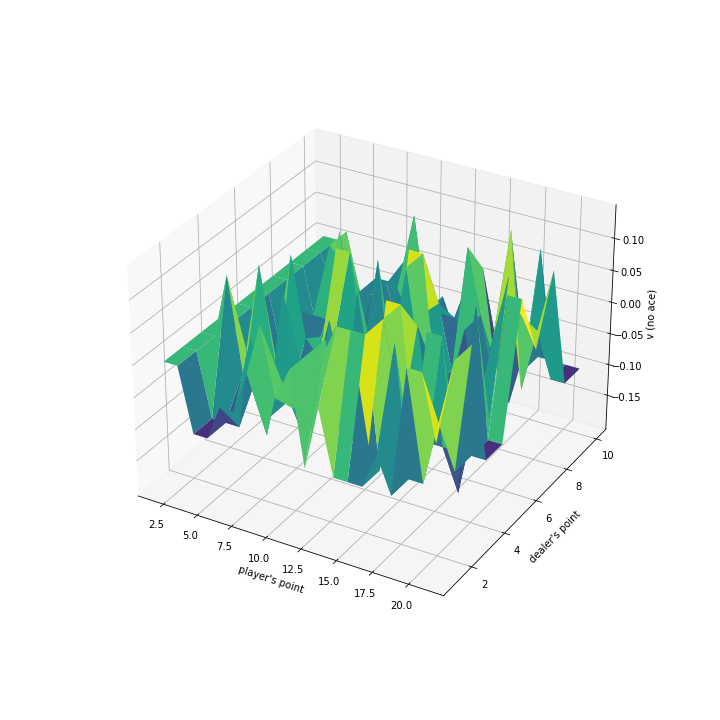

In [11]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
x = np.arange(2,22)
y = np.arange(1,v.shape[1])
X, Y = np.meshgrid(x, y) 
Z = v[X,Y,0]

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('player\'s point')
ax.set_ylabel('dealer\'s point')
ax.set_zlabel('v (no ace)')

## epsilon greedy tabular q-learning

In [4]:
env = gym.make('Blackjack-v1')
epsilon = 0.8
agent = agents.epsilonGreedyAgent(env, epsilon, learning_rate=0.1)
acc = experience.Accumulator(100,10)
trainer = experiment.Trainer(env, acc, './log/eps_q_tab_blackjack/exp1')

In [5]:
train_episodes = 1000
key, train_key = random.split(key)
trainer.train(train_key, agent, train_episodes)

100%|███████████████| 1000/1000 [00:29<00:00, 33.97it/s]


In [12]:
v = agent.appr.table

Text(0.5, 0, 'v (no ace)')

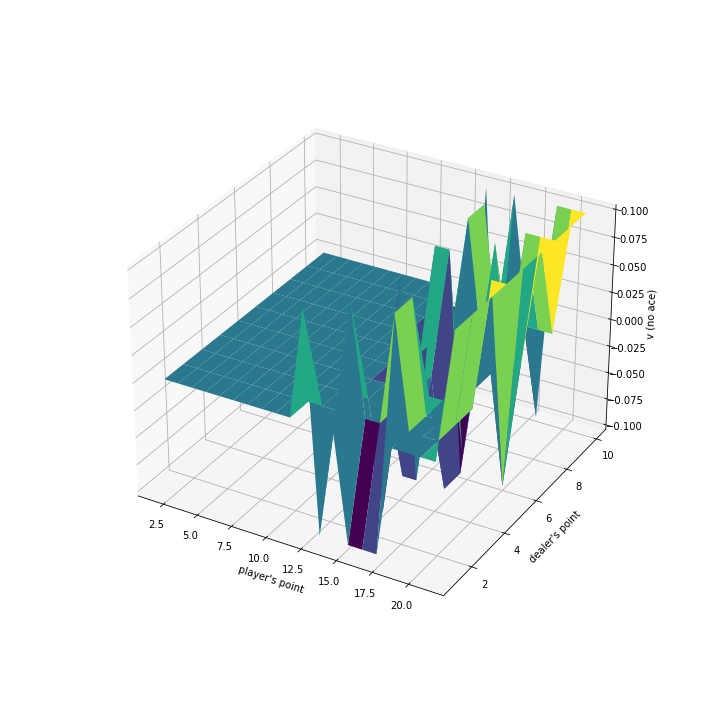

In [18]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
x = np.arange(2,22)
y = np.arange(1,v.shape[1])
X, Y = np.meshgrid(x, y) 
Z = v[X,Y,1,0]

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('player\'s point')
ax.set_ylabel('dealer\'s point')
ax.set_zlabel('v (no ace)')

## epsilon greedy linear function appr agent

### Blackjack

In [11]:
env = gym.make('Blackjack-v1')
epsilon = 0.8
agent = agents.epsLinearAgent(env, epsilon, learning_rate=0.001)
acc = experience.Accumulator(100,10)
trainer = experiment.Trainer(env, acc, './log/eps_q_lin_blackjack/exp1')

In [12]:
train_episodes = 10000
key, train_key = random.split(key)
trainer.train(train_key, agent, train_episodes)

100%|███████████████| 10000/10000 [01:42<00:00, 97.57it/s]


In [13]:
x = np.arange(2,22)
y = np.arange(1,12)
X, Y = np.meshgrid(x, y)
mesh_states = jnp.array([[ jnp.array([ix, jy, 0]) for ix in x] for jy in y])
apply_linear_2d = jax.vmap(jax.vmap(approximator.LinearApproximator.v, in_axes=(None, 0)), in_axes=(None, 0))
Z = jax.jit(apply_linear_2d)(agent.appr.W, agent.norm_state(mesh_states))

In [19]:
Z[:,:,0].shape

(11, 20)

In [14]:
agent.appr.W

DeviceArray([[ -8.113118  , -12.111881  ,  -3.0351417 ],
             [  1.6739488 ,   1.9746832 ,   0.07358897]], dtype=float32)

Text(0.5, 0, 'v (no ace)')

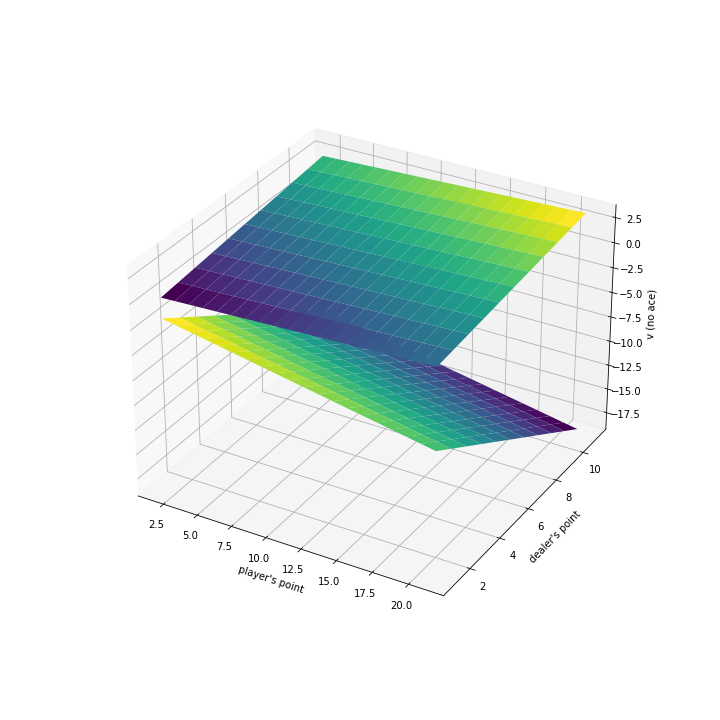

In [22]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z[:,:,0], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot_surface(X, Y, Z[:,:,1], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('player\'s point')
ax.set_ylabel('dealer\'s point')
ax.set_zlabel('v (no ace)')

### Cartpole

In [4]:
env = gym.make('CartPole-v1')
epsilon = 1
agent = epsLinearAgent(env, epsilon, eps_decay_rate=1-1e-3, learning_rate=.1, lr_decay=.9)
acc = experience.Accumulator(501,20, 10)
trainer = experiment.Trainer(env, acc, './log/eps_q_lin_cartpole/exp26')

In [5]:
train_episodes = 2000
key, train_key = random.split(key)
trainer.train(train_key, agent, train_episodes, is_continue=False)

100%|███████████████| 2000/2000 [07:57<00:00,  4.19it/s]


In [6]:
agent.appr.W

DeviceArray([[ 0.00138178,  0.00460247, -0.01166468, -0.00526811],
             [ 0.00069706,  0.00150193, -0.01111232, -0.00168003]],            dtype=float32)

observation space = `[position, velocity, pole angle, pole angular velocity]`  

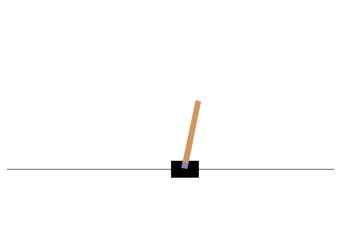

In [15]:
from IPython import display
import time
observation = env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
plt.axis('off')
for _ in range(500):
    key, act_key = random.split(key)
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action, _ = agent.eval_act(jnp.array(observation), act_key)
    observation, reward, done, info = env.step(action)
    if done:
        break
    time.sleep(0.1)
    

## Test `NN`

In [15]:
from agents.dqn import MLP_TargetNetwork, get_transformed
import haiku as hk

In [16]:
hk.Transformed

haiku._src.transform.Transformed

In [14]:
tn = get_transformed(MLP_TargetNetwork, output_sizes= [3,2])
type(tn)

haiku._src.transform.Transformed

In [11]:
params = tn.init(rng=key, x=jnp.zeros((4,)))
output = tn.apply(params, x=jnp.ones((4,)))
print(params, output)

{'MLP_TargetNetwork/~/internal_linear/~/linear_0': {'w': DeviceArray([[-0.33604547,  0.79630965, -0.18870588],
             [ 0.19167897, -0.35731745,  0.3903272 ],
             [ 0.34503296,  0.00294389,  0.108395  ],
             [ 0.50890297, -0.77481896, -0.86317194]], dtype=float32), 'b': DeviceArray([0., 0., 0.], dtype=float32)}, 'MLP_TargetNetwork/~/internal_linear/~/linear_1': {'w': DeviceArray([[-0.18024886, -0.22352378],
             [ 0.48430356,  0.63834244],
             [ 0.5929914 , -0.56017804]], dtype=float32), 'b': DeviceArray([0., 0.], dtype=float32)}} [-0.12789908 -0.15860565]


In [20]:
params2 = params
params2 = jax.tree_map(lambda x: x*2, params2)
params, params2

({'MLP_TargetNetwork/~/internal_linear/~/linear_0': {'w': DeviceArray([[-0.33604547,  0.79630965, -0.18870588],
                [ 0.19167897, -0.35731745,  0.3903272 ],
                [ 0.34503296,  0.00294389,  0.108395  ],
                [ 0.50890297, -0.77481896, -0.86317194]], dtype=float32),
   'b': DeviceArray([0., 0., 0.], dtype=float32)},
  'MLP_TargetNetwork/~/internal_linear/~/linear_1': {'w': DeviceArray([[-0.18024886, -0.22352378],
                [ 0.48430356,  0.63834244],
                [ 0.5929914 , -0.56017804]], dtype=float32),
   'b': DeviceArray([0., 0.], dtype=float32)}},
 {'MLP_TargetNetwork/~/internal_linear/~/linear_0': {'b': DeviceArray([0., 0., 0.], dtype=float32),
   'w': DeviceArray([[-0.67209095,  1.5926193 , -0.37741175],
                [ 0.38335794, -0.7146349 ,  0.7806544 ],
                [ 0.6900659 ,  0.00588778,  0.21679   ],
                [ 1.0178059 , -1.5496379 , -1.7263439 ]], dtype=float32)},
  'MLP_TargetNetwork/~/internal_linear/~/linea

# Random stuff

In [7]:
a = jnp.arange(10).astype(float)
b = 2*a

In [11]:
def f(a,b):
  return jnp.sum(a+b)

jax.grad(f)(a,2*a)

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

### Comparing deque vs np.array(dtype=object)

In [48]:
import collections
from typing import NamedTuple, Any
import numpy as np

class Transition(NamedTuple):
  s_tm1: Any
  a_tm1: Any
  s_t: Any
  r_t: float = 0.0
  trace: Any = None
  priority: float =1

In [56]:
test_size = 10000
a = Transition(
      s_tm1=jnp.array([1,2,3]),
      a_tm1 = 2,
      s_t = jnp.array([1,2,3]),
      r_t = 4
    )
a

Transition(s_tm1=DeviceArray([1, 2, 3], dtype=int32), a_tm1=2, s_t=DeviceArray([1, 2, 3], dtype=int32), r_t=4, trace=None, priority=1)

In [57]:
np_deq = np.array([None]*test_size, dtype=object)
deq = collections.deque(maxlen=test_size)
%timeit np_deq[0] = a
%timeit deq.append(a)

51.2 ns ± 1.46 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
39.7 ns ± 1.15 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [64]:
np_deq = np.array([None]*test_size, dtype=object)
deq = collections.deque(maxlen=test_size)
for i in range(test_size):
  np_deq[i] = a
  deq.append(a)

for size in [i*test_size//10 for i in range(3,6)]:
  print("query size = ", size)
  idx = np.random.randint(test_size, size=size)

# accessing takes microseconds
  %timeit tmp = np_deq[idx]
  %timeit tmp = [deq[i] for i in idx]
  
# multimaping takes milliseconds 
  %timeit jax.tree_multimap(lambda *x: np.stack(x) ,*np_deq[idx])
  %timeit jax.tree_multimap(lambda *x: np.stack(x) ,*[deq[i] for i in idx])

query size =  3000
9.63 µs ± 287 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
344 µs ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
31.3 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.7 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
query size =  4000
12.4 µs ± 297 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
451 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
39.9 ms ± 973 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
42 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
query size =  5000
16.4 µs ± 214 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
571 µs ± 22.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
48.5 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.5 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
np_deq[random.randint(key, (10,), 0, 5)]

/tmp/ipykernel_235/3626825097.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  np_deq[list(random.randint(key, (10,), 0, 5))]


IndexError: too many indices for array: array is 1-dimensional, but 10 were indexed

In [107]:
%timeit np.asarray(random.randint(key, (1000,), 0, 5))

594 µs ± 40 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
